## Online Retail Customer Segmentation - K-Means and Hierarchical Clustering Solution

## 1. Problem Statement

A UK-based online retail company aims to enhance its marketing strategy by targeting customers with **personalized and relevant offers**. To achieve this, the company seeks to segment its customers based on their transactional behavior. By analyzing approximately one year of transaction data, key metrics such as `Recency` (time since the last purchase), `Frequency` (number of purchases), and `Monetary` value (total spend) were derived to represent customer behavior. 

The goal is to segment customers into distinct categories—such as high-value, medium-value, and low-value segments—based on these metrics. This segmentation will enable the company to identify its most valuable customers, optimize marketing campaigns, and improve customer engagement and retention.

<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for the UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

### 1.1 Objectives

The problem involves exploring and applying clustering techniques, specifically **K-Means and Hierarchical clustering**, to achieve meaningful and actionable customer segmentation.

### 1.2 Approach

The steps we would follow for this exercise are broadly:

1. Read and Visualise the Data
2. Clean the Data
3. Transform the Data for Modelling
4. Create K-Means Model
5. Create Hierarchical Clustering Model
6. Conclusion

## 2. Read and Visualise the Data

In [269]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [270]:
# Read the dataset
retail_df = pd.read_csv("Online_Retail.csv", sep=",", encoding="ISO-8859-1", header=0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [271]:
# Review the dataset information
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## 3. Clean the Data

In [273]:
# Handle missing values
round(100*(retail_df.isnull().sum())/len(retail_df), 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

Customer ID is missing in 24.93% of transactions. Since Customer ID is the most crucial parameter to segment the customers, not having this value renders these transactions useless. Hence we should drop these transactions from the input dataset.

In [275]:
# Drop all rows having missing values
retail_df = retail_df.dropna()
retail_df.shape

(406829, 8)

In [276]:
# Review the dataframe structure
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [277]:
# Add a new feature - amount - which is the total value of each order
retail_df['amount'] = retail_df['Quantity']*retail_df['UnitPrice']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


## 4. Transform the Data for Modelling

### 4.1 Prepare RFM Summary Data

We would compute three important metrics for customer segmentation that will be used for modelling:

- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [281]:
# Add monetary summary
summary_df = retail_df.groupby('CustomerID')['amount'].sum()
summary_df = summary_df.reset_index()
summary_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [282]:
# Prepare frequency summary
frequency_df = retail_df.groupby('CustomerID')['InvoiceNo'].count()
frequency_df = frequency_df.reset_index()
frequency_df.columns = ['CustomerID', 'frequency']
frequency_df.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [283]:
# Merge the two dfs
summary_df = pd.merge(summary_df, frequency_df, on='CustomerID', how='inner')
summary_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [284]:
# Prepare to add recency summary
# Convert to InvoiceDate to datetime format
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], 
                                          format='%d-%m-%Y %H:%M')

In [285]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [286]:
# Determine the max date - recency to be computed w.r.t. this max date
max_date = max(retail_df['InvoiceDate'])
max_date.strftime("%d-%m-%Y")

'09-12-2011'

In [287]:
# Compute the invoice date diff from max date
retail_df['date_diff'] = max_date - retail_df['InvoiceDate']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,date_diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [288]:
# Prepare the recency summary
last_purchase_df = retail_df.groupby('CustomerID')['date_diff'].min()
last_purchase_df = last_purchase_df.reset_index()
last_purchase_df.head()

,CustomerID,date_diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [289]:
# Merge the recency summary to total summary dataframe
summary_df = pd.merge(summary_df, last_purchase_df, on='CustomerID', how='inner')
summary_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']
summary_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [290]:
# Convert recency to number of days only
summary_df['recency'] = summary_df['recency'].dt.days
summary_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


### 4.2 Handle Outliers in Summary Data

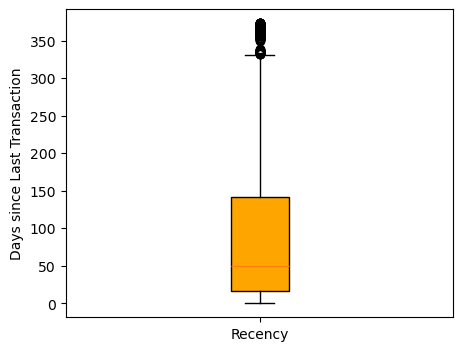

In [292]:
# Treat outliers for recency
fig, ax = plt.subplots()
ax.boxplot(summary_df['recency'], patch_artist=True, 
            boxprops=dict(facecolor='orange'))
ax.set_xticklabels(['Recency'])
ax.set_ylabel('Days since Last Transaction')
plt.show()

In [293]:
# Remove (statistical) outliers

# Outlier treatment for amount
Q1 = summary_df.amount.quantile(0.05)
Q3 = summary_df.amount.quantile(0.95)
IQR = Q3 - Q1
summary_df = summary_df[(summary_df.amount >= Q1 - 1.5*IQR) & (summary_df.amount <= Q3 + 1.5*IQR)]

# Outlier treatment for recency
Q1 = summary_df.recency.quantile(0.05)
Q3 = summary_df.recency.quantile(0.95)
IQR = Q3 - Q1
summary_df = summary_df[(summary_df.recency >= Q1 - 1.5*IQR) & (summary_df.recency <= Q3 + 1.5*IQR)]

# Outlier treatment for frequency
Q1 = summary_df.frequency.quantile(0.05)
Q3 = summary_df.frequency.quantile(0.95)
IQR = Q3 - Q1
summary_df = summary_df[(summary_df.frequency >= Q1 - 1.5*IQR) & (summary_df.frequency <= Q3 + 1.5*IQR)]


### 4.3 Scale the Summary Data

In [295]:
# Create dataframe for training
rfm_df = summary_df[['amount', 'frequency', 'recency']]

# Instantiate scaler
scaler = StandardScaler()

# Scale the data
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [296]:
# Create the scaled dataframe
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


## 5. Create K-Means Model

### 5.1 Create Initial Model

In [299]:
# !pip install --upgrade threadpoolctl

In [300]:
# Create k-means model with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=4)

In [301]:
kmeans.labels_

array([1, 0, 2, ..., 1, 2, 2], dtype=int32)

In [302]:
# help(KMeans)

### 5.2 Find the Optimal Number of Clusters

Perform Sum of Squared Distance (SSD) analysis

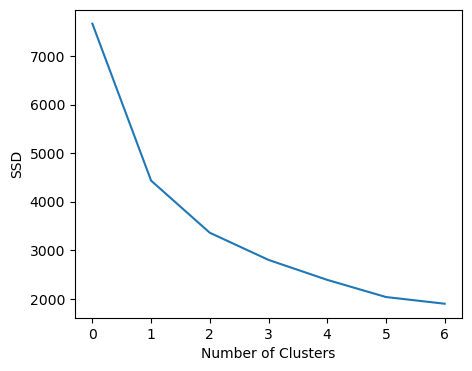

In [304]:
# Create elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, n_init='auto')
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
fig, ax = plt.subplots()
ax.plot(ssd)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('SSD')
plt.show()

Elbow takes place at tick label 1 i.e. when the number of clusters is 3. That is the optimum number of clusters as per the elbow curve analysis

### 5.3 Perform Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [307]:
# Perform silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # Intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, n_init='auto')
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # Compute Silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.48506020563508856
For n_clusters=5, the silhouette score is 0.4645801831125689
For n_clusters=6, the silhouette score is 0.44296906681722065
For n_clusters=7, the silhouette score is 0.41481670613813887
For n_clusters=8, the silhouette score is 0.4088806924321585


The Silhoutte score tapers down at n_clusters=4

In [309]:
# Create final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50, n_init='auto')
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3, n_init='auto')

In [310]:
kmeans.labels_

array([2, 0, 1, ..., 2, 1, 1], dtype=int32)

In [311]:
# Assign the Cluster labels to Customers
summary_df['cluster_id'] = kmeans.labels_
summary_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,2


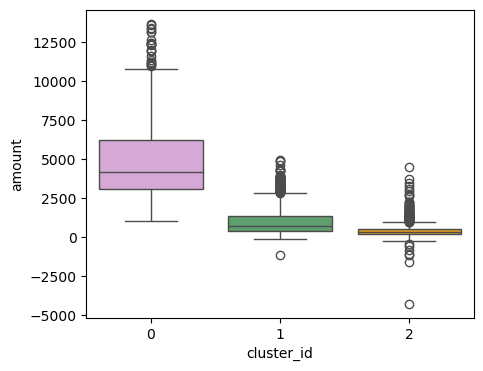

In [312]:
# Create boxplot of summary data based on cluster labels
sns.boxplot(x='cluster_id', y='amount', data=summary_df, hue='cluster_id', palette=['plum', 'g', 'orange'], legend=False)
plt.show()

There are three clusters based on transacted values - High Value Customers (median amount = ~4K), Medium Value Customers (median amount = ~1K) and Low Value Customers (median amount = ~0.5K)

## 6. Create Hierarchical Clustering Model

In [315]:
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


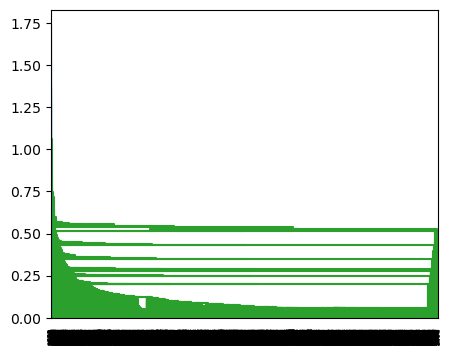

In [316]:
# Use single linkage
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

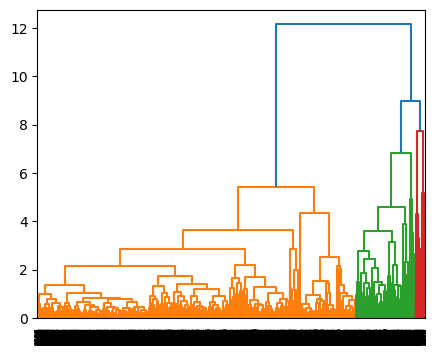

In [317]:
# Use complete linkage
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [318]:
# Cut the tree for 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 0, ..., 0, 0, 0])

In [319]:
# Assign cluster labels
summary_df['cluster_labels'] = cluster_labels
summary_df.head()

,CustomerID,amount,frequency,recency,cluster_id,cluster_labels
0,12346.0,0.00,2,325,2,0
1,12347.0,4310.00,182,1,0,1
2,12348.0,1797.24,31,74,1,0
3,12349.0,1757.55,73,18,1,0
4,12350.0,334.40,17,309,2,0


In [320]:
# set figure size
plt.rcParams['figure.figsize'] = (5, 4)  # Set new figure size

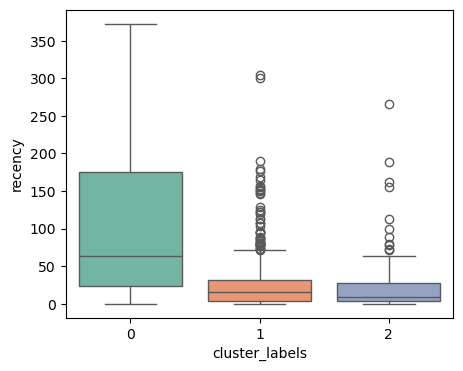

In [321]:
# Display boxplots for recency
sns.boxplot(x='cluster_labels', y='recency', data=summary_df, hue='cluster_labels', palette='Set2', legend=False)
plt.show()

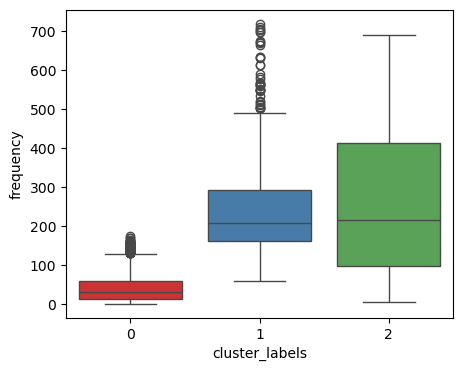

In [322]:
# Display boxplots for frequency
sns.boxplot(x='cluster_labels', y='frequency', data=summary_df, hue='cluster_labels', palette='Set1', legend=False)
plt.show()

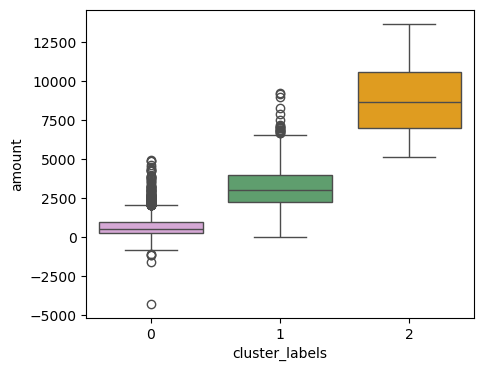

In [323]:
# Display boxplots for recency
sns.boxplot(x='cluster_labels', y='amount', data=summary_df, hue='cluster_labels', palette=['plum', 'g', 'orange'], legend=False)
plt.show()

As observed from the plots of hierarchical model results, the Cluster-2 customers are most rewarding for the Retail Company who spend significantly higher amounts more frequently and more recently. Compared to this, Cluster-0 customers spend less, with less frequency and least recency.

## 7. Conclusion

The Clustering models, particularly the Hierarchical model, has done a very good job of identifying the **customer segments** with distinct spending behaviours. This would help the Retail Company to extend loyalty benefits to **High Value customers** to retain them as loyal customers for long. At the same time, they should try to entice the **Low Value customers** with appealing offers to make them open their purses more often with larger outgo. The Clustering model is proved to be very effective in addressing segmentation requirements not only in retail, but also in banking & finance, document and text clustering in NLP, image segmentation in computer vision, anomaly detection in cybersecurity etc.